In [14]:
import pandas as pd
import pyarrow
from dotenv import load_dotenv
import os
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import geopandas as gpd
from shapely import wkt
import numpy as np

le = LabelEncoder()

load_dotenv()

file_path = os.getenv('FILE_PATH')
print(file_path)

b:/Matrixian/


In [15]:
df_sample = pd.read_parquet(file_path + "detailed_woning_type_sample.parquet")
df = pd.read_csv(file_path + "bag_image_summary.csv", dtype="string")
df_joined = pd.merge(df_sample, df, how="left", right_on="bag_id", left_on="bag_nummeraanduidingid")
df_sample_with_urls = df_joined[df_joined["frontview_exists"].notna()]
print(os.path.abspath(file_path + "sample_with_urls.csv"))
print(df_sample_with_urls.columns)


b:\Matrixian\sample_with_urls.csv
Index(['bag_nummeraanduidingid', 'source_data_result_id', 'special_house_type',
       'woningtype', 'straatnaam', 'postcode', 'huisnr', 'huisnr_bag_letter',
       'huisnr_bag_toevoeging', 'plaatsnaam', 'opp_pand', 'oppervlakte',
       'build_year', 'build_type', 'is_monument', 'is_protected',
       'source_data_timestamp', 'geometry', 'random_rank', 'bag_id',
       'num_funda_images', 'frontview_exists', 'frontview_funda_url',
       'frontview_google_url', 'frontview_funda_in_business_url'],
      dtype='object')


In [16]:
df_sample_with_urls = df_sample_with_urls.drop(columns=[
    'bag_id', 'source_data_result_id', 'random_rank', 
    'frontview_funda_url', 'frontview_google_url', 'frontview_funda_in_business_url', 
    'special_house_type', 'source_data_timestamp', 'frontview_exists'
])

print(df_sample_with_urls.columns)


Index(['bag_nummeraanduidingid', 'woningtype', 'straatnaam', 'postcode',
       'huisnr', 'huisnr_bag_letter', 'huisnr_bag_toevoeging', 'plaatsnaam',
       'opp_pand', 'oppervlakte', 'build_year', 'build_type', 'is_monument',
       'is_protected', 'geometry', 'num_funda_images'],
      dtype='object')


In [17]:
know_col = ['bag_nummeraanduidingid', 'woningtype']

# getallen 
numerical_cols = ['opp_pand', 'oppervlakte', 'build_year', 'num_funda_images']

# woorden 
categorical_cols = ['straatnaam', 'postcode', 'huisnr_bag_letter', 'huisnr_bag_toevoeging', 'plaatsnaam', 'build_type']

# waarschijnlijk niet nodig
boolean_cols = ['is_monument', 'is_protected']


In [18]:
df_sample_with_urls.to_csv(file_path + "sample_with_urls.csv", index=False)

In [19]:
# New var
# procent_ingenomen
# opp_pand / oppervlakte = procent_ingenomen
df_sample_with_urls['procent_ingenomen'] = df_sample_with_urls['opp_pand'] / df_sample_with_urls['oppervlakte']

numerical_cols = ['opp_pand', 'oppervlakte', 'build_year', 'num_funda_images', 'huisnr']
# opp_pand 0 - inf
# Niks mee gedaan, kan hoog oplopen maar het nadeel van scale tot 0 - 1 is dat je geen grotere panden kan toevoegen en je het verschil tussen 100 en 200 minder groot maakt omdat die allebei zo dicht bij 0 gaan liggen 
# Standard hoe ver van het gemiddelde af
scaler = StandardScaler()
df_sample_with_urls ['opp_pand']= scaler.fit_transform(df_sample_with_urls[['opp_pand']])

# oppervlakte 0 - inf
# Niks mee gedaan, kan hoog oplopen maar het nadeel van scale tot 0 - 1 is dat je geen grotere panden kan toevoegen en je het verschil tussen 100 en 200 minder groot maakt omdat die allebei zo dicht bij 0 gaan liggen 
df_sample_with_urls['oppervlakte'] = scaler.fit_transform(df_sample_with_urls[['oppervlakte']])

# build_year 0 - 2025
df_sample_with_urls ['build_year']= scaler.fit_transform(df_sample_with_urls[['build_year']])

# num_funda_images NaN, 0 - inf
# weg gehaald, want veel of weinig fotos kan niks zeggen over het type huis en al zal dat wel kunnen, willen we het model daar niet op trainen

# huisnr


categorical_cols = ['straatnaam', 'postcode', 'huisnr_bag_letter', 'huisnr_bag_toevoeging', 'plaatsnaam', 'build_type']
# straatnaam naam
# 2d vector naar locatie
# df['straatnaam'] = df['straatnaam'].str.strip().str.lower()


# postcode 4(0-9) + 2(a-z)
# 2d vector naar locatie

# huisnr_bag_letter NaN of a-z

# van 0 tot 1 waar niks = 0, a = 1/27, z = 1
# def letter_score(val):
#     if isinstance(val, str) and val.isalpha():
#         return (ord(val.lower()) - ord('a') + 1) / 26
#     return 0.0
# df_sample_with_urls['huisnr_bag_letter_score'] = df_sample_with_urls['huisnr_bag_letter'].map(letter_score)

df_sample_with_urls['huisnr_bag_letter'] = df_sample_with_urls['huisnr_bag_letter'].notna().astype(int)

# huisnr_bag_toevoeging NaN of x(a-z) of x(0-9) of x(a-z,0-9)
df_sample_with_urls['huisnr_bag_toevoeging'] = df_sample_with_urls['huisnr_bag_toevoeging'].notna().astype(int)

# plaatsnaam naam
# 2d vector naar locatie
# df['plaatsnaam'] = df['plaatsnaam'].str.strip().str.lower()


# build_type 5 types
build_type = df_sample_with_urls[['build_type']]
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_array = encoder.fit_transform(build_type)
raw_feature_names = encoder.get_feature_names_out(['build_type'])
clean_feature_names = [name.replace(' ', '_') for name in raw_feature_names]
encoded_df = pd.DataFrame(encoded_array, columns=clean_feature_names, index=df_sample_with_urls.index)
df_sample_with_urls.drop('build_type', axis=1, inplace=True)
df_sample_with_urls = pd.concat([df_sample_with_urls, encoded_df], axis=1)

boolean_cols = ['is_monument', 'is_protected']
# is_monument NaN, 0 - 1
df_sample_with_urls['is_monument'] = df_sample_with_urls['is_monument'].fillna(0).astype(int)

# is_protected NaN, 0 - 1
df_sample_with_urls['is_protected'] = df_sample_with_urls['is_protected'].fillna(0).astype(int)



In [20]:
df_sample_with_urls['geometry'] = df_sample_with_urls['geometry'].apply(wkt.loads)

df_sample_with_urls['centroid_x'] = df_sample_with_urls['geometry'].apply(lambda geom: geom.centroid.x)
df_sample_with_urls['centroid_y'] = df_sample_with_urls['geometry'].apply(lambda geom: geom.centroid.y)

df_sample_with_urls['area'] = df_sample_with_urls['geometry'].apply(lambda geom: geom.area)

# perimeter = Sum of the lengths of all edges forming the boundary of a polygon
df_sample_with_urls['perimeter'] = df_sample_with_urls['geometry'].apply(lambda g: g.length)

# Gives 1 for a perfect circle (most compact shape)
# Gets closer to 0 for long, skinny, jagged shapes
df_sample_with_urls['compactness'] = (
    4 * np.pi * df_sample_with_urls['area'] / (df_sample_with_urls['perimeter'] ** 2)
)

df_sample_with_urls['num_vertices'] = df_sample_with_urls['geometry'].apply(lambda g: len(g.exterior.coords))


<Axes: xlabel='compactness', ylabel='Count'>

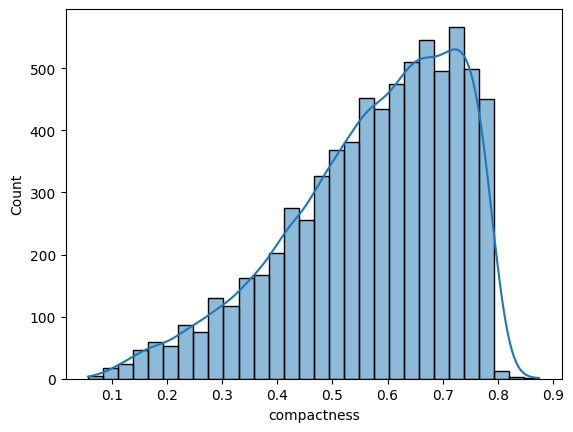

In [21]:
import seaborn as sns
sns.histplot(df_sample_with_urls['compactness'], bins=30, kde=True)

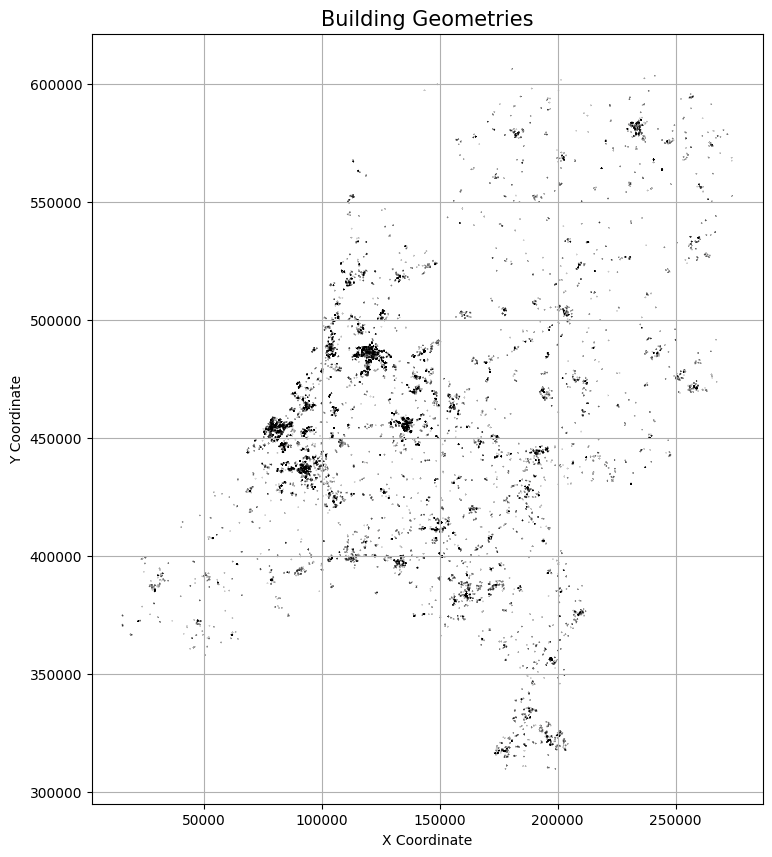

In [22]:
gdf = gpd.GeoDataFrame(df_sample_with_urls, geometry='geometry')
gdf.plot(figsize=(10, 10), edgecolor='black', facecolor='lightblue')

plt.title("Building Geometries", fontsize=15)
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()


In [23]:
df_sample_with_urls = df_sample_with_urls.drop(columns=[
    'num_funda_images', 'straatnaam', 
    'postcode', 'plaatsnaam'
])

df_sample_with_urls.to_csv(file_path + "cleaned_sample_with_urls.csv", index=False)

print(df_sample_with_urls.columns)

Index(['bag_nummeraanduidingid', 'woningtype', 'huisnr', 'huisnr_bag_letter',
       'huisnr_bag_toevoeging', 'opp_pand', 'oppervlakte', 'build_year',
       'is_monument', 'is_protected', 'geometry', 'procent_ingenomen',
       'build_type_Appartement', 'build_type_Hoekwoning',
       'build_type_Tussen_of_geschakelde_woning', 'build_type_Tweeonder1kap',
       'build_type_Verschillend', 'build_type_Vrijstaande_woning',
       'centroid_x', 'centroid_y', 'area', 'perimeter', 'compactness',
       'num_vertices'],
      dtype='object')


In [ ]:
features = [
    'huisnr',                                       # 0 - inf
    'huisnr_bag_letter',                            # 0 - 1
    'huisnr_bag_toevoeging',                        # 0 - 1
    'opp_pand',                                     # StandardScaler
    'oppervlakte',                                  # StandardScaler
    'build_year',                                   # StandardScaler
    'is_monument',                                  # 0 - 1
    'is_protected',                                 # 0 - 1
    'procent_ingenomen',                            # 0 - 1
    'build_type_Appartement',                       # OneHotEncoder
    'build_type_Hoekwoning',                        # OneHotEncoder
    'build_type_Tussen_of_geschakelde_woning',      # OneHotEncoder
    'build_type_Tweeonder1kap',                     # OneHotEncoder
    'build_type_Verschillend',                      # OneHotEncoder

    # work in process
    'centroid_x', 
    'centroid_y', 
    'area', 
    'perimeter', 
    'compactness', 
    'num_vertices'
]

target = 'woningtype'

In [25]:
X = df_sample_with_urls[features]
y = df_sample_with_urls[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


                                 precision    recall  f1-score   support

            2-onder-1-kapwoning       0.59      0.62      0.60       100
                  Benedenwoning       0.46      0.40      0.43       100
                    Bovenwoning       0.35      0.29      0.32       100
                   Corridorflat       0.54      0.33      0.41        39
                     Eindwoning       0.48      0.45      0.46       100
                    Galerijflat       0.45      0.65      0.53       100
Geschakelde 2-onder-1-kapwoning       0.60      0.72      0.65       100
             Geschakelde woning       0.34      0.23      0.27       100
         Halfvrijstaande woning       0.35      0.27      0.30       100
                     Hoekwoning       0.39      0.39      0.39       100
                    Maisonnette       0.36      0.36      0.36       100
                    Portiekflat       0.33      0.40      0.36       100
                  Portiekwoning       0.45      0.

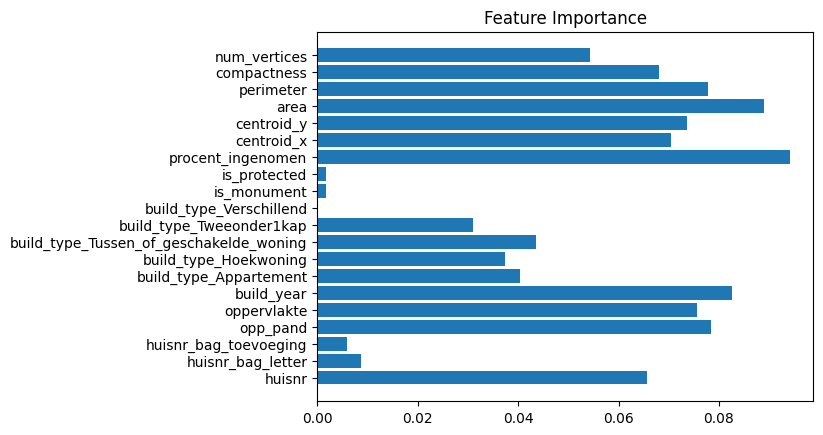

In [26]:
importances = model.feature_importances_
plt.barh(features, importances)
plt.title("Feature Importance")
plt.show()